In [1]:
# imports and small helper functions
import math
import sys
from typing import Dict, Tuple, List

# parse weight input string; treat 'na' (any case) as missing connection
def parse_weight_input(s: str):
    s = s.strip()
    if s.lower() in ("na", "n/a", ""):
        return None
    try:
        return float(s)
    except:
        return None

# prompt helpers for integers and floats with optional defaults
def ask_int(prompt: str, default=None):
    while True:
        try:
            v = input(prompt).strip()
            if v == "" and default is not None:
                return default
            iv = int(v)
            return iv
        except Exception:
            print("Please enter an integer.")

def ask_float(prompt: str, default=None):
    while True:
        v = input(prompt).strip()
        if v == "" and default is not None:
            return default
        try:
            return float(v)
        except:
            print("Please enter a number.")

In [2]:
# Node class implementing scalar values and local backward rules
class Node:
    
    def __init__(self, out: float, prev=()):
        self.out = float(out)
        self.delta = 0.0
        self._prev = tuple(prev)
        self._backward = lambda: None
        self.label = ""

    def __repr__(self):
        return f"Node(label={self.label!r}, out={self.out:.6f}, delta={self.delta:.6f})"

    # Addition: z = a + b
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        out = Node(self.out + other.out, (self, other))
        def _backward():
            # ∂(a+b)/∂a = 1, ∂(a+b)/∂b = 1
            self.delta += 1.0 * out.delta
            other.delta += 1.0 * out.delta
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    # Multiplication: z = a * b
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        out = Node(self.out * other.out, (self, other))
        def _backward():
            # ∂(a*b)/∂a = b ; ∂(a*b)/∂b = a
            self.delta += other.out * out.delta
            other.delta += self.out * out.delta
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    # Negation and subtraction helpers
    def __neg__(self):
        out = Node(-self.out, (self,))
        def _backward():
            self.delta += -1.0 * out.delta
        out._backward = _backward
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        return self + (-other)

    def __rsub__(self, other):
        other = other if isinstance(other, Node) else Node(float(other))
        return other - self

    # Power (integer exponent) support, used for squared error
    def __pow__(self, exponent: int):
        out = Node(self.out ** exponent, (self,))
        def _backward():
            if exponent != 0:
                self.delta += exponent * (self.out ** (exponent - 1)) * out.delta
        out._backward = _backward
        return out


In [3]:
# activation functions and backward/topological traversal

def sigmoid(node: Node, lam: float = 1.0):
    
    #Sigmoid activation with scale parameter lambda:
    #O = sigmoid(lambda * n) = 1 / (1 + exp(-lambda * n))
    #Local derivative: dO/dn = lambda * O * (1 - O)
    
    s = 1.0 / (1.0 + math.exp(-lam * node.out))
    out = Node(s, (node,))
    def _backward():
        node.delta += lam * (out.out * (1.0 - out.out)) * out.delta
    out._backward = _backward
    return out

def tanh_node(node: Node):
    
    #tanh activation and its derivative:
    #O = tanh(n), dO/dn = 1 - tanh(n)^2
    
    t = math.tanh(node.out)
    out = Node(t, (node,))
    def _backward():
        node.delta += (1.0 - out.out * out.out) * out.delta
    out._backward = _backward
    return out

def linear(node: Node):
    
    # Identity activation: O = n ; derivative = 1
    
    out = Node(node.out, (node,))
    def _backward():
        node.delta += 1.0 * out.delta
    out._backward = _backward
    return out

def build_topo(root: Node):
    
    visited = set()
    topo = []
    def dfs(n):
        if id(n) in visited:
            return
        visited.add(id(n))
        for p in n._prev:
            dfs(p)
        topo.append(n)
    dfs(root)
    return topo

def backward(root: Node):
    
    # Perform backward pass starting from root (the final scalar loss).
    # Sets root.delta = 1.0 and calls each node's local _backward in reverse topo order.
    root.delta = 1.0
    topo = build_topo(root)
    for n in reversed(topo):
        n._backward()


Neural Network Calculator
Options:
A : Forward pass (no weight update)
B : Backpropagation (compute gradients and update weights; optionally run forward with updated weights)


Enter A or B:  A


Choose activation for all hidden/output neurons: sigmoid / tanh / linear


Activation (default sigmoid):  sigmoid
Enter sigmoid lambda (λ) (default 1.0):  1
Number of input neurons (layer 1) (e.g. 2):  2
Value for input neuron 0:  0.35
Value for input neuron 1:  0.9
Number of hidden layers (0 allowed):  1
Number of neurons in hidden layer 1:  2
Number of output neurons (final layer) (e.g. 1):  1



Enter connection weights between consecutive layers.
If a connection does not exist, enter NA (or na).

Connections from layer 0 (size 2) to layer 1 (size 2).


Weight from layer0_neuron0 -> layer1_neuron0:  0.1
Weight from layer0_neuron0 -> layer1_neuron1:  0.4
Weight from layer0_neuron1 -> layer1_neuron0:  0.8
Weight from layer0_neuron1 -> layer1_neuron1:  0.6



Connections from layer 1 (size 2) to layer 2 (size 1).


Weight from layer1_neuron0 -> layer2_neuron0:  0.3
Weight from layer1_neuron1 -> layer2_neuron0:  0.9



Forward pass outputs:
Output neuron 0 : 0.690283


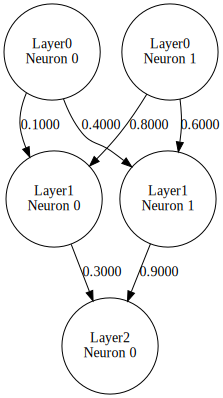

In [4]:
# network collection, graph build, forward, backprop, updates, and Graphviz

def collect_network_for_forward(allow_weights_input=True):

    print("Choose activation for all hidden/output neurons: sigmoid / tanh / linear")
    act_choice = input("Activation (default sigmoid): ").strip().lower() or "sigmoid"
    lam = 1.0
    if act_choice == "sigmoid":
        lam = ask_float("Enter sigmoid lambda (λ) (default 1.0): ", default=1.0)

    in_count = ask_int("Number of input neurons (layer 1) (e.g. 2): ")
    inputs = []
    for i in range(in_count):
        val = ask_float(f"Value for input neuron {i}: ")
        inputs.append(val)

    hidden_layers = ask_int("Number of hidden layers (0 allowed): ")
    hidden_counts = []
    for h in range(hidden_layers):
        c = ask_int(f"Number of neurons in hidden layer {h+1}: ")
        hidden_counts.append(c)

    out_count = ask_int("Number of output neurons (final layer) (e.g. 1): ")

    layer_sizes = [in_count] + hidden_counts + [out_count]
    total_layers = len(layer_sizes)

    weights = {}
    print("\nEnter connection weights between consecutive layers.")
    print("If a connection does not exist, enter NA (or na).")
    for L in range(total_layers - 1):
        n_from = layer_sizes[L]
        n_to = layer_sizes[L+1]
        print(f"\nConnections from layer {L} (size {n_from}) to layer {L+1} (size {n_to}).")
        for i in range(n_from):
            for j in range(n_to):
                if allow_weights_input:
                    s = input(f"Weight from layer{L}_neuron{i} -> layer{L+1}_neuron{j}: ").strip()
                    w = parse_weight_input(s)
                else:
                    w = None
                if w is None:
                    pass
                else:
                    weights[(L, i, j)] = float(w)

    return {
        "activation": act_choice,
        "lambda": lam,
        "layer_sizes": layer_sizes,
        "inputs": inputs,
        "weights": weights
    }

def build_graph(params, make_weights_nodes=True):

    act = params["activation"]
    lam = params["lambda"]
    sizes = params["layer_sizes"]
    inputs_vals = params["inputs"]
    raw_weights = params["weights"]

    input_nodes = [Node(v) for v in inputs_vals]
    for idx, n in enumerate(input_nodes):
        n.label = f"in{idx}"

    weight_nodes = {}
    layer_nodes = [input_nodes]

    total_layers = len(sizes)
    for L in range(1, total_layers):
        n_to = sizes[L]
        prev_nodes = layer_nodes[L-1]
        act_nodes = []
        for j in range(n_to):
            sum_node = None
            connected = False
            for i, inp in enumerate(prev_nodes):
                key = (L-1, i, j)
                if key in raw_weights:
                    connected = True
                    if make_weights_nodes:
                        if key not in weight_nodes:
                            wnode = Node(raw_weights[key])
                            wnode.label = f"w_{L-1}_{i}_{j}"
                            weight_nodes[key] = wnode
                        w = weight_nodes[key]
                    else:
                        w = Node(raw_weights[key])
                    term = inp * w
                    if sum_node is None:
                        sum_node = term
                    else:
                        sum_node = sum_node + term
            if sum_node is None:
                sum_node = Node(0.0)
            sum_node.label = f"n_{L}_{j}"
            if act == "sigmoid":
                out_node = sigmoid(sum_node, lam=lam)
            elif act == "tanh":
                out_node = tanh_node(sum_node)
            else:
                out_node = linear(sum_node)
            out_node.label = f"O_{L}_{j}"
            act_nodes.append(out_node)
        layer_nodes.append(act_nodes)
    return input_nodes, layer_nodes, weight_nodes

def run_forward(params, build_weights=True):
    
    in_nodes, layers, weight_nodes = build_graph(params, make_weights_nodes=build_weights)
    outputs = layers[-1]
    return in_nodes, layers, weight_nodes, outputs

def run_backprop(params, targets, eta):

    in_nodes, layers, weight_nodes, outputs = run_forward(params, build_weights=True)
    loss_node = None
    for t, o in zip(targets, outputs):
        tn = Node(t); tn.label = "T"
        diff = tn - o
        sq = 0.5 * (diff * diff)
        if loss_node is None:
            loss_node = sq
        else:
            loss_node = loss_node + sq
    loss_node.label = "L"
    backward(loss_node)
    updated_weights = {}
    for key, wnode in weight_nodes.items():
        grad = wnode.delta
        old = wnode.out
        wnode.out = old - eta * grad
        updated_weights[key] = (old, wnode.out, grad)
    return loss_node, updated_weights, in_nodes, layers, outputs, weight_nodes

def show_graphviz(params, weight_nodes, layers):

    try:
        from graphviz import Digraph, Source
    except Exception:
        print("Neural Network cannot be shown because Graphviz is not properly installed")
        return
    dot = Digraph(comment="Neural Network")
    total_layers = len(params["layer_sizes"])
    for L in range(total_layers):
        for idx in range(params["layer_sizes"][L]):
            nid = f"n_{L}_{idx}"
            label = f"Layer{L}\\nNeuron {idx}"
            dot.node(nid, label=label, shape="circle")
    for (L,i,j), w in params["weights"].items():
        if (L,i,j) in weight_nodes:
            wval = weight_nodes[(L,i,j)].out
        else:
            wval = params["weights"][(L,i,j)]
        u = f"n_{L}_{i}"
        v = f"n_{L+1}_{j}"
        dot.edge(u, v, label=f"{wval:.4f}")
    try:
        src = Source(dot.source)
        display(src)  # works in Jupyter/Kaggle; if fails, fallback will catch it
    except Exception:
        print("Graphviz available but could not display inline. DOT source below:")
        print(dot.source)

# Main interactive flow
def main():
    print("Neural Network Calculator")
    print("Options:")
    print("A : Forward pass (no weight update)")
    print("B : Backpropagation (compute gradients and update weights; optionally run forward with updated weights)")
    choice = input("Enter A or B: ").strip().upper()
    if choice not in ("A", "B"):
        print("Invalid choice. Exiting.")
        return

    params = collect_network_for_forward(allow_weights_input=True)

    if choice == "A":
        in_nodes, layers, weight_nodes, outputs = run_forward(params, build_weights=True)
        print("\nForward pass outputs:")
        for idx, o in enumerate(outputs):
            print(f"Output neuron {idx} : {o.out:.6f}")
        show_graphviz(params, weight_nodes, layers)
        return

    out_count = params["layer_sizes"][-1]
    targets = []
    print(f"Enter {out_count} target value(s) for output layer:")
    for j in range(out_count):
        t = ask_float(f"Target for output neuron {j}: ")
        targets.append(t)
    eta = ask_float("Enter learning rate η (e.g. 0.01): ", default=0.01)

    loss_node, updated_weights, in_nodes, layers, outputs, weight_nodes = run_backprop(params, targets, eta)
    print("\nBackpropagation complete.")
    print(f"Loss (before update): {loss_node.out:.10f}")
    print("\nUpdated weights (old -> new) and gradients:")
    if not updated_weights:
        print("No connections were provided, so no weights updated.")
    else:
        for key,(old,new,grad) in updated_weights.items():
            L,i,j = key
            print(f"Weight layer{L}_n{i} -> layer{L+1}_n{j} : {old:.6f} -> {new:.6f} (grad={grad:.6e})")

    run_post = input("\nRun forward pass with updated weights? (Y/n) ").strip().lower() or "y"
    if run_post[0] == "y":
        new_weights = {}
        for k,v in params["weights"].items():
            if k in weight_nodes:
                new_weights[k] = weight_nodes[k].out
            else:
                new_weights[k] = v
        params2 = {
            "activation": params["activation"],
            "lambda": params["lambda"],
            "layer_sizes": params["layer_sizes"],
            "inputs": params["inputs"],
            "weights": new_weights
        }
        _, layers2, _, outputs2 = run_forward(params2, build_weights=False)
        print("\nForward outputs after weight update:")
        for idx,o in enumerate(outputs2):
            print(f"Output neuron {idx} : {o.out:.6f}")
        show_graphviz(params2, weight_nodes, layers2)
    else:
        show_graphviz(params, weight_nodes, layers)

if __name__ == "__main__":
    main()
